In [39]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.collections as collections
import matplotlib.colors as mcolors

np.set_printoptions(precision=4)

# Problem Statement

The structure is an idealized structure shown below with the loading and boundary condition as shown. This structure is part of my homework for a finite element method class.

The node numbering are shown and the element numbering are notated with red box. The finite element type to be used in this problem is Q4 which is a quadrilateral element with four nodes. The structure is further assumed to follow **plane stress** conditions. The thickness is assumed to be 1 inch.

The nodal displacements and element stresses and strains are calculated using finite element analysis procedure.

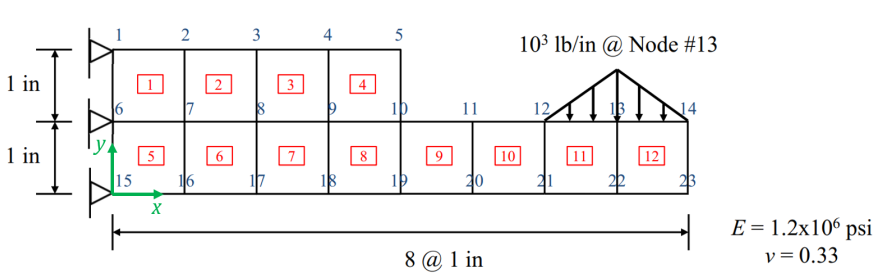

## Define base units

The base units are used for readability purposes of this script. The base units are defined below. All outputs will be of the form of base units (unless conversion is done).

In [40]:
# define base units
lb   = 1.0 # Forces: lb
inch = 1.0 # Length: in

psi = lb/inch**2
ksi = 1000*psi

# Define discretization (or mesh) of the structure and material properties

The coordinates of each node is encoded to `gcoord`. The connectivity of each element (defines the nodes that are connected to an element) is encoded to the variable `elems`. Take note that python indexing starts with `0`.

In [41]:
# global coordinates of each node
gcoord = np.array([[0*inch, 2*inch],   # node 1
                   [1*inch, 2*inch],   # node 2
                   [2*inch, 2*inch],   # node 3
                   [3*inch, 2*inch],   # node 4
                   [4*inch, 2*inch],   # node 5
                   [0*inch, 1*inch],   # node
                   [1*inch, 1*inch],   # node
                   [2*inch, 1*inch],   # node
                   [3*inch, 1*inch],   # node
                   [4*inch, 1*inch],   # node
                   [5*inch, 1*inch],   # node
                   [6*inch, 1*inch],   # node
                   [7*inch, 1*inch],   # node
                   [8*inch, 1*inch],   # node
                   [0*inch, 0*inch],   # node
                   [1*inch, 0*inch],   # node
                   [2*inch, 0*inch],   # node
                   [3*inch, 0*inch],   # node
                   [4*inch, 0*inch],   # node
                   [5*inch, 0*inch],   # node
                   [6*inch, 0*inch],   # node
                   [7*inch, 0*inch],   # node
                   [8*inch, 0*inch]])  # node 23

# nodal connectivity
elems = np.array([[0,5,6,1],
                  [1,6,7,2],
                  [2,7,8,3],
                  [3,8,9,4],
                  [5,14,15,6],
                  [6,15,16,7],
                  [7,16,17,8],
                  [8,17,18,9],
                  [9,18,19,10],
                  [10,19,20,11],
                  [11,20,21,12],
                  [12,21,22,13]]) # element

thickness = 1*inch

# Material properties
E_mod    = 1.2*10**6*psi   # Modulus of elasticity
poisson  = 0.33            # Poisson ratio
option   = 1               # Plane stress


Base on the figure above we also define the boundary conditions. The nodes 1, 5 and 14 are pinned or constrained in the x and y direction of translation. This information saved in the `bc` array.

In [42]:
# specify boundary conditions
bc = np.array([[0,0,0], # node 1
               [0,1,0],
               [5,0,0], # node 6
               [5,1,0],
               [14,0,0],# node 15
               [14,1,0]])

The other preliminaries are also defined such as the number of dof per node (which 2 for Q4), number of elements, number of nondes, etc.

In [43]:
n_dof = 2
n_elems  = elems.shape[0]
n_nodes = gcoord.shape[0]

elem_n_node = 4
elem_dof = n_dof*elem_n_node

# Define loading condition

In this notebook, the equivalent nodal loads (based from the linearly varying load described above) are computed manually. Basic structural mechanics concepts can be used to solve this equivalent nodal loads. Alternatively, use of shape functions and performing numerical integration can be used to calculate the equivalent nodal loads.

In [44]:
# initialized nodal load vector
f = np.zeros((2*n_nodes,1) )

# manually define loads at specific dofs (based from figure above)
f[2*11+1] = -500/3          # force applied at node12  in y-axis
f[2*12+1] = -2000/3         # force applied at node13  in y-axis
f[2*13+1] = -500/3          # force applied at node14  in y-axis

Plot the connectivity of the elements before proceeding with the analysis.

In [45]:
def fem2dplotQ4(gcoord, elems, c, title,axon):
  # Create patches
  patch = [patches.Polygon(gcoord[face], edgecolor= c,
                                           facecolor='none') for face in elems]
  collection = collections.PatchCollection(patch, match_original=True)
  ax.add_collection(collection)

  ax.set_xlim(0, 9); ax.set_ylim(-2, 3);
  ax.set_aspect('equal')

  if axon == False:
    ax.set_axis_off()

  ax.set_title(title)

  return 0

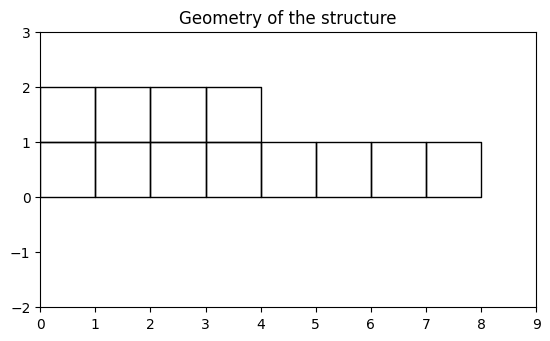

In [46]:
fig, ax = plt.subplots()

title = 'Geometry of the structure'
axon = True

# plot underformed
fem2dplotQ4(gcoord, elems, 'black',title,axon)

plt.show()


# Determine element stiffness matrix and assemble global stiffness matrix

The procedure of the assembly of the element and global stiffness matrix is rather involved. The readers of this python notebook are refered to FEm textbooks on this procedure.

The following functions are defined first:
- `fem2diso` - this creates the constitutive relation matrix $[D]$ from $\sigma = [D]\epsilon$. The contents of this matrix depends whether it is plane stress or plane strain.
- `deriv` - this calculates the following values: $\frac{\partial N}{\partial s}$ and $\frac{\partial N}{\partial t}$. This will be used to performed numerical integration
- `jac` - calculates the partial derivatives of the shape function wrt x and y ($\frac{\partial N}{\partial x}$, $\frac{\partial N}{\partial y}$ ) and the jacobian matrix
- `fem2dkine` - this calculates the kinematic matrix or commonly known as the `B` matrix which is used to determine the stiffnes matrix of the element
- `fem2dassemble`- this function assembles the global stiffness matrix based on the correspondence of element dof to the global dof.

In [47]:
def fem2diso(option, E, v):
  '''
  Determine the constitutive equation for isotropic material.
  option = 1: plane stress
  option = 2: plane strain
  '''
  if option == 1:   # plane stress
    D_matrix = (E/(1-v**2))* np.array([[1,v,0],
                                       [v,1,0],
                                       [0,0,(1-v)/2]])

  elif option == 2: # plane strain
    D_matrix = (E/((1+v)*(1-2*v)) )* np.array([[1-v,v,0],
                                               [v,1-v,0],
                                               [0,0, (1-2*v)/2]])

  return D_matrix

In [48]:
def deriv(s,t):
    '''
    Calculate the derivative of the shape function in the s and t coordinates
    (Parent coordinates)
    '''
    dNds = (1/4)*np.array([[-1+t, 1-t,  1+t,-1-t]] )
    dNdt = (1/4)*np.array([[-1+s, -1-s, 1+s,1-s]] )
    return dNds, dNdt

In [49]:
def jac(XY, dNds, dNdt):
    '''
    Calculate the Jacobian matrix and derivatives of shape functions w.r.t.
    the parent coordinates (x and y).
    '''
    jacobian = np.vstack((dNds, dNdt) ) @ XY.T
    dNdxdy   = np.linalg.inv(jacobian) @ np.vstack((dNds, dNdt) )

    dNdx = dNdxdy[0,:]
    dNdy = dNdxdy[1,:]
    return dNdx, dNdy, jacobian

In [50]:
def fem2dkine(elem_n_node, dNdx, dNdy):
    '''
    Assembles the kinematic matrix (B-matrix) for the given element.
    '''
    B_matrix = np.zeros((3, 2*elem_n_node) )
    B_matrix[0,[0,2,4,6] ] = dNdx
    B_matrix[1,[1,3,5,7] ] = dNdy
    B_matrix[2,[0,2,4,6] ] = dNdy
    B_matrix[2,[1,3,5,7] ] = dNdx

    return B_matrix

In [51]:
def fem2dassemble(K_g, k, elnodes, elem_n_node,n_dof):
    '''
    Assembles the global stiffness matrix (K_g) for the given element.
    '''
    eldofs = np.zeros(n_dof*elem_n_node)
    for i in range(elem_n_node):
      for n in range(n_dof):
        eldofs[2*i+n] = n_dof*elnodes[i]+n
    eldofs = np.array(eldofs,dtype=int)

    K_g[np.ix_(eldofs,eldofs)] = K_g[np.ix_(eldofs,eldofs)] + k

    return K_g

The global stiffness matrix `K_g` is assembled by firstly calculating the each of the element stiffness matrices.

In [52]:
D_matrix = fem2diso(option,E_mod,poisson)

K_g = np.zeros((2*n_nodes,2*n_nodes) )  # initialize the global stiffness matrix

for elem_i in range(n_elems):           # loop for the total number of elements

    # Get corresponding coordinates of each node connected to an element
    elnodes = elems[elem_i,:]
    x1,y1 = gcoord[elnodes[0],0], gcoord[elnodes[0],1]
    x2,y2 = gcoord[elnodes[1],0], gcoord[elnodes[1],1]
    x3,y3 = gcoord[elnodes[2],0], gcoord[elnodes[2],1]
    x4,y4 = gcoord[elnodes[3],0], gcoord[elnodes[3],1]
    XY = np.array([[x1,x2,x3,x4],
                   [y1,y2,y3,y4]])

    # 2-point Gauss quadrature Weights and Integration points
    W = np.array([1,1,1,1])
    intpts = np.array([[-sqrt(1/3), sqrt(1/3), sqrt(1/3),-sqrt(1/3)],
                       [-sqrt(1/3),-sqrt(1/3), sqrt(1/3), sqrt(1/3)]])

    k = np.zeros((elem_dof, elem_dof) ) # element stiffness matrix
    for i in range(elem_n_node):
      # Use isoparametric formulation x,y --> s,t
      dNds, dNdt = deriv(intpts[0,i],intpts[1,i])
      dNdx, dNdy, jacobian = jac(XY, dNds, dNdt)
      B_matrix = fem2dkine(elem_n_node, dNdx, dNdy)
      # perform numerical integration
      k = k + (B_matrix.T @ D_matrix @ B_matrix)*np.linalg.det(jacobian)*W[i]*thickness

    # assemble global stiffness matrix
    K_g = fem2dassemble(K_g, k, elnodes, elem_n_node,n_dof)

# Solve for the unknown displacements

The global stiffnes matrix above is singular and symmetric. The unknown displacements in the equation: $\{f\} =[K_g]\{u\} $ cannot yet be calculated.

The known or *specified* dofs should be identified first. For this problem, the support or boundary conditions are known nodal displacements (equal to 0). The over all dofs should be classifed to specified dofs (variable `dofspec`) and unknown or free (to move) dofs (variable `doffree`).

In [53]:
# define all dofs
alldofs = np.arange(0,2*n_nodes) # python indexing starts with 0

# determine index of specified dof
dofspec = []
for i in range(bc.shape[0] ):
  thisdof = 2*(bc[i,0]) + bc[i,1]
  dofspec.append(thisdof)
dofspec = np.array(dofspec).astype(int)
#print(dofspec)

# determine index of free dof
doffree = alldofs
doffree = np.array(doffree)
doffree = np.delete(doffree, dofspec, axis=0)
#print(doffree)# determine index of free dof

In [54]:
# initialize nodal displacement vector
u = np.zeros((2*n_nodes,1) )

# define
u[dofspec,0] = bc[:,2]

Once the free and specified dofs are identified. The Force and Displacement relation of the global structure can be reduced in the manner shown below:

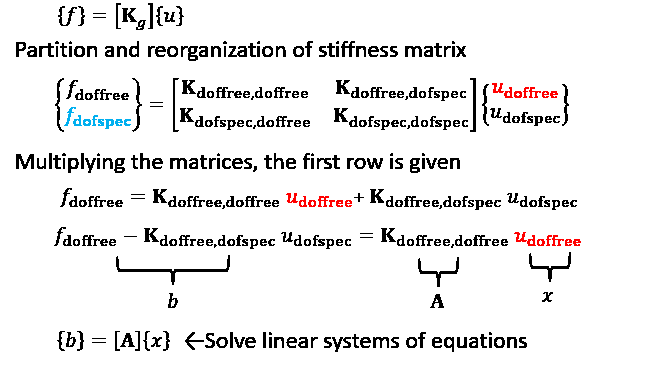

In [55]:
A = K_g[np.ix_(doffree,doffree)]
b = f[np.ix_(doffree)] - np.dot(K_g[np.ix_(doffree,dofspec)],u[np.ix_(dofspec)])
u[np.ix_(doffree)] = np.linalg.solve(A,b);
#print(f'The nodal displacements: \n{u}\n')

The reactions can also be calculated as follows:

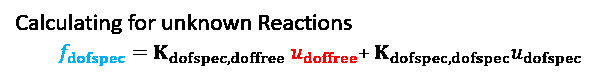

In [56]:
f[np.ix_(dofspec)] = np.dot(K_g[np.ix_(dofspec,doffree)],u[np.ix_(doffree)] ) + np.dot(K_g[np.ix_(dofspec,dofspec)],u[np.ix_(dofspec)] )

print(f'The reactions are: \n{f[np.ix_(dofspec)]}\n')

The reactions are: 
[[-3.4993e+03]
 [ 7.7467e+02]
 [-1.3524e+00]
 [-5.5290e+02]
 [ 3.5007e+03]
 [ 7.7824e+02]]



The stress and strain for each elements can be calculated by using the calculated displacments per node.

In [57]:
strains, stress = np.zeros((n_elems,3) ), np.zeros((n_elems,3) )

for elem_i in range(n_elems):           # loop for the total number of elements

    elnodes = elems[elem_i,:]
    x1,y1 = gcoord[elnodes[0],0], gcoord[elnodes[0],1]
    x2,y2 = gcoord[elnodes[1],0], gcoord[elnodes[1],1]
    x3,y3 = gcoord[elnodes[2],0], gcoord[elnodes[2],1]
    x4,y4 = gcoord[elnodes[3],0], gcoord[elnodes[3],1]

    XY = np.array([[x1,x2,x3,x4],
                   [y1,y2,y3,y4]])

    eldofs = np.zeros(n_dof*elem_n_node)
    for i in range(elem_n_node):
      for n in range(n_dof):
        eldofs[2*i+n] = n_dof*elnodes[i]+n
    eldofs = np.array(eldofs,dtype=int)

    eldisp = np.zeros((elem_dof, 1) )
    for i in range(len(eldofs) ):
      eldisp[i] = u[eldofs[i] ]

    # 2-point Gauss quadrature Weights and Integration points
    W = np.array([1,1,1,1])
    intpts = np.array([[-sqrt(1/3), sqrt(1/3), sqrt(1/3),-sqrt(1/3)],
                       [-sqrt(1/3),-sqrt(1/3), sqrt(1/3), sqrt(1/3)]])

    k = np.zeros((elem_dof, elem_dof) )

    for i in range(elem_n_node):
      # Use isoparametric formulation x,y --> s,t
      dNds, dNdt = deriv(intpts[0,i],intpts[1,i])
      dNdx, dNdy, jacobian = jac(XY, dNds, dNdt)
      B_matrix = fem2dkine(elem_n_node, dNdx, dNdy)
      elstrain = (B_matrix @ eldisp)

    elstress = D_matrix @ elstrain
    strains[elem_i,:] = elstrain.T
    stress[elem_i,:]  = elstress.T

In [69]:
# Print table header
header = ["Element"] + ["Axial Stress-X"] + ["Axial Stress-Y"] + ["Shear Stress-XY"]
print("\t".join(header))
print("-" * 50)

# Print stress values for each element
for elem_i in range(n_elems):
    stress_values = "\t".join(f"{val:.5f}" for val in stress[elem_i, :])  # Format to 4 decimal places
    print(f"{elem_i+1}\t{stress_values}")

Element	Axial Stress-X	Axial Stress-Y	Shear Stress-XY
--------------------------------------------------
1	6960.50378	1044.26235	247.32474
2	6134.46585	824.82620	378.46029
3	4507.00688	-251.06957	-363.61147
4	1917.34924	1707.49230	-1585.07511
5	-1525.87571	772.93139	575.46680
6	-1368.59261	644.02962	205.75164
7	-781.81702	54.95413	493.02168
8	1586.98194	1882.28592	2146.54315
9	6276.73992	2204.45124	959.64361
10	3923.35745	1241.53842	335.48320
11	1466.46836	144.16511	-374.15872
12	254.22057	-68.92249	-55.66755


In [72]:
# Print table header
header = ["Element"] + ["Axial Strain-X"] + ["Axial Strain-Y"] + ["Shear Strain-XY"]
print("\t".join(header))
print("-" * 50)

# Print stress values for each element
for elem_i in range(n_elems):
    strains_values = "\t".join(f"{val:.6f}" for val in strains[elem_i, :])  # Format to 4 decimal places
    print(f"{elem_i+1}\t{strains_values}")

Element	Axial Strain-X	Axial Strain-Y	Shear Strain-XY
--------------------------------------------------
1	0.005513	-0.001044	0.000548
2	0.004885	-0.001000	0.000839
3	0.003825	-0.001449	-0.000806
4	0.001128	0.000896	-0.003514
5	-0.001484	0.001064	0.001276
6	-0.001318	0.000913	0.000456
7	-0.000667	0.000261	0.001093
8	0.000805	0.001132	0.004758
9	0.004624	0.000111	0.002127
10	0.002928	-0.000044	0.000744
11	0.001182	-0.000283	-0.000829
12	0.000231	-0.000127	-0.000123


# Post processing of results

The stresses and deformation can be illustrated using python plotting functionalities.

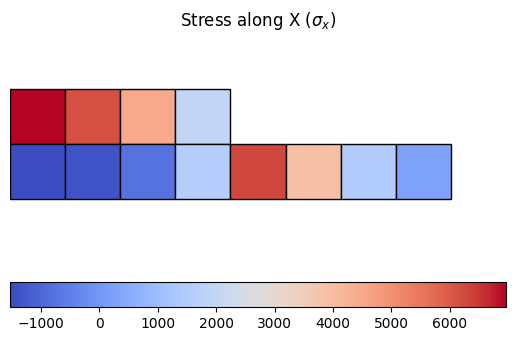

In [58]:
fig, ax = plt.subplots()

# Create patches for undeformed
stress_x = stress[:,0]

# Normalize stress for color mapping
stress_min, stress_max = min(stress_x), max(stress_x)
norm = mcolors.Normalize(vmin=stress_min, vmax=stress_max)

cmap = plt.get_cmap('coolwarm')
colors = cmap(norm(stress_x))
patches_undeformed = [patches.Polygon(gcoord[face]) for face in elems]
collection = collections.PatchCollection(patches_undeformed, edgecolor = 'black',facecolors=colors)
ax.add_collection(collection)


# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This line is necessary for the colorbar to work properly
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal')

ax.set_xlim(0, 9)
ax.set_ylim(-0.5, 3)
ax.set_aspect('equal')

ax.set_title('Stress along X ($\sigma_x$)')

ax.set_axis_off()

plt.show()

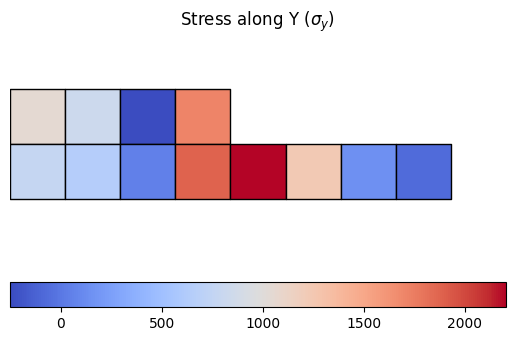

In [59]:
fig, ax = plt.subplots()

# Create patches for undeformed


stress_y = stress[:,1]

# Normalize stress for color mapping
stress_min, stress_max = min(stress_y), max(stress_y)
norm = mcolors.Normalize(vmin=stress_min, vmax=stress_max)

cmap = plt.get_cmap('coolwarm')
colors = cmap(norm(stress_y))
patches_undeformed = [patches.Polygon(gcoord[face]) for face in elems]
collection = collections.PatchCollection(patches_undeformed, edgecolor = 'black',facecolors=colors)
ax.add_collection(collection)


# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This line is necessary for the colorbar to work properly
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal')

ax.set_xlim(0, 9)
ax.set_ylim(-0.5, 3)
ax.set_aspect('equal')

ax.set_title('Stress along Y ($\sigma_y$)')

ax.set_axis_off()

plt.show()

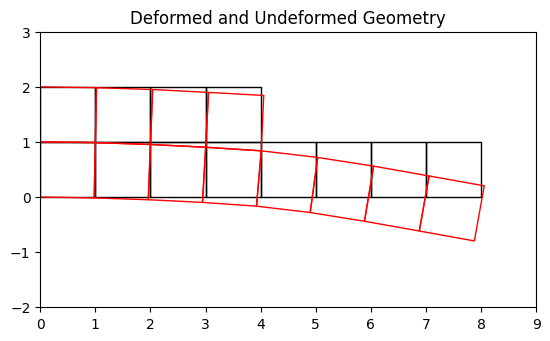

In [60]:
fig, ax = plt.subplots()

title = 'Deformed and Undeformed Geometry'
axon = True

# plot underformed
fem2dplotQ4(gcoord, elems, 'black',title,axon)

# plot deformed shape
scale = 3
gcoord_deformed = gcoord + scale * u.reshape(n_nodes,2)
fem2dplotQ4(gcoord_deformed, elems, 'red',title,axon)

plt.show()
